In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [6]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [7]:
# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)


[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.16s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.22s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.23s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.21s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.22s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.22s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.21s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.23s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.23s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.24s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 0.22s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.26s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 0.24s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -19.61, time = 0.21s
[BernoulliRBM] Iteration 15, 

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=0,
                   warm_start=False)

In [8]:
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.90      0.91      0.91       184
           2       0.92      0.95      0.93       166
           3       0.97      0.89      0.93       194
           4       0.96      0.93      0.95       186
           5       0.93      0.93      0.93       181
           6       0.98      0.97      0.98       207
           7       0.92      0.99      0.95       154
           8       0.90      0.90      0.90       182
           9       0.91      0.93      0.92       169

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       174
           1       0.60      0.58      0.59  

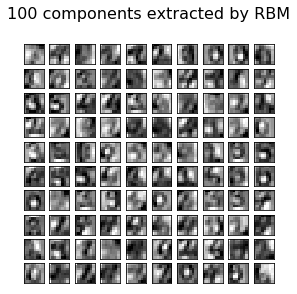

In [9]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()